In [1]:
import sys
if 'google.colab' in sys.modules:
    import os
    from google.colab import files
    # just check if we already uploaded, may we restart the runtime and run all cells
    if not os.path.isfile('Data Ermera Timor Leste.xlsx'):
        uploaded = files.upload()

Saving Data Ermera Timor Leste.xlsx to Data Ermera Timor Leste.xlsx


In [2]:
import pandas as pd

data = pd.read_excel( 'Data Ermera Timor Leste.xlsx', sheet_name=None )

import matplotlib.pyplot as plt
%matplotlib inline

# Prerequisites for mathematical optimization


In [3]:
import shutil
if not shutil.which('pyomo'):
    !pip install -q pyomo
    assert(shutil.which('pyomo'))

import sys
if 'google.colab' in sys.modules:
    !apt-get install -y -qq coinor-cbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.0 MB/s eta 0:00:00
Selecting previously unselected package coinor-libcoinutils3v5:amd64.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-2_amd64.deb ...
Unpacking coinor-libcoinutils3v5:amd64 (2.11.4+repack1-2) ...
Selecting previously unselected package coinor-libosi1v5:amd64.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-2_amd64.deb ...
Unpacking coinor-libosi1v5:amd64 (0.108.6+repack1-2) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1:amd64.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-3_amd64.deb ...
Unpacking coinor-libcgl1:amd64 (0.60.3+repack1-3

In [4]:
import pyomo.environ as pyo
from pyomo.environ import (
    ConcreteModel,
    Param,
    Var,
    PositiveReals,
    Objective,
    Constraint,
    maximize,
    SolverFactory,
)

# Modelling and solving the model


In [10]:
def template(distances, homes, locations, maxFacilities, maximumDistance):
  model = ConcreteModel("Timor Leste")

  model.I = pyo.Set(initialize = homes.index)
  model.J = pyo.Set(initialize = locations.index)

  model.z = pyo.Var(model.I, within=pyo.Binary)
  model.x = pyo.Var(model.J, within=pyo.Binary)

  model.sum = pyo.Objective(
      sense = pyo.maximize,
      expr = pyo.quicksum((model.z[i] for i in model.I))
  )

  def openMax(model, i):
    return(0, pyo.quicksum((model.x[j]) for j in model.J), maxFacilities)
  model.openMax = pyo.Constraint(rule=openMax)

  def maxDistance(model, i):
    return sum(model.x[j] for j in model.J if distances[j][i] < maximumDistance) >= model.z[i]
  model.maxDistance = pyo.Constraint(model.I, rule=maxDistance)
  return model

In [11]:
distances = data['Distances']
homes     = data['Homes']
locations = data['Potential locations']
maxFacilities = 6
maximumDistance = 2

model = template(distances, homes, locations, maxFacilities, maximumDistance)

In [12]:
%time results = pyo.SolverFactory('cbc').solve(model)

CPU times: user 88.6 ms, sys: 3.86 ms, total: 92.5 ms
Wall time: 308 ms


#Solution Visualization

In [13]:
def ShowFacilityLocation( xC, yC, xF, yF, X, Y, served=pyo.value(model.sum) ):
    plt.plot( xC,yC, 'o' )
    plt.plot( xF,yF, 's', mfc='none' )
    [plt.plot( xC[i], yC[i], 'o', color="g") for i in range(len(Y)) if Y[i]]
    for j in range(len(X)):
      if X[j] > .5:
        plt.plot( xF[j],yF[j], 's', color='y' )
    if not served is None:
        plt.title( '{:.2f}%'.format(served/len(xC)*100) )
    plt.show()

In [14]:
plt.rcParams["figure.figsize"] = (13,8)

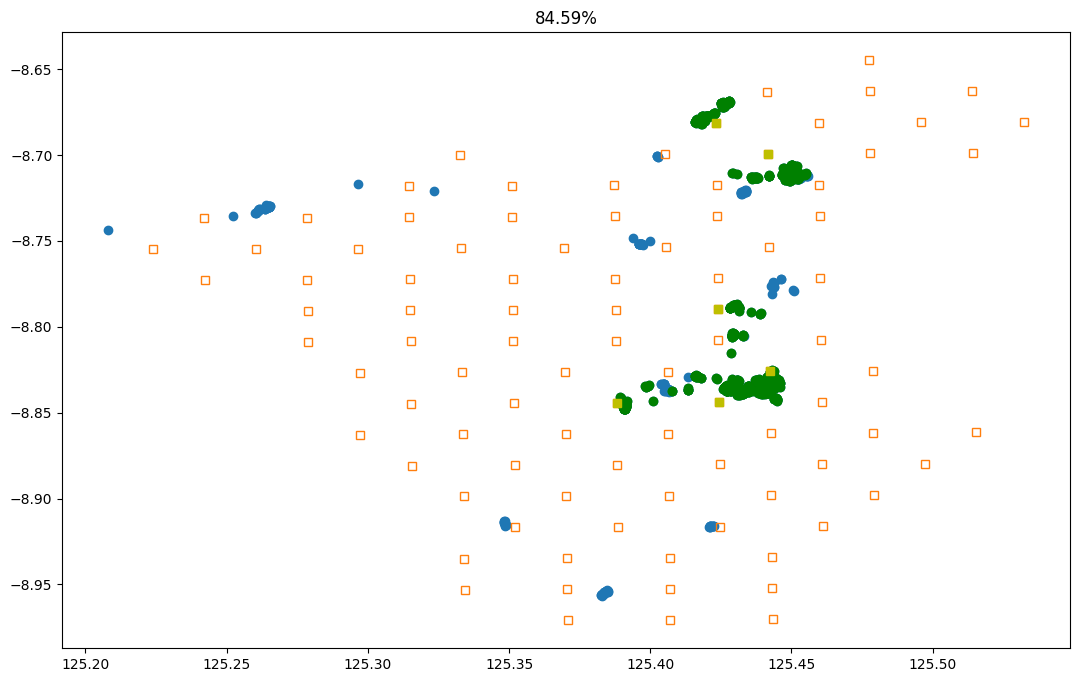

In [16]:
xC = homes['lon']
yC = homes['lat']
xF = locations['lon']
yF = locations['lat']
X=[pyo.value(model.x[j]) for j in model.J]
Z=[pyo.value(model.z[i]) for i in model.I]
ShowFacilityLocation( xC, yC, xF, yF, X, Z )